In [2]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
import itertools
from copy import deepcopy

# Statistics
from tslearn import barycenters
from scipy.stats import wasserstein_distance

# Classification
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedGroupKFold, cross_validate, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline

# add path to classification analysis functions
from mixed_sigmoid_normalisation import MixedSigmoidScaler

# Add rpy2
%load_ext rpy2.ipython

In [3]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [17]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_time_resolved_barycenter_res_list = []

# Load in time-resolved barycenter results
for barycenter_time_res_file in glob(f"{deriv_dir}/time_series_features/averaged_epochs/*pyspi_barycenter_sq*.csv"):
    barycenter_time_resolved_res = pd.read_csv(barycenter_time_res_file)
    all_time_resolved_barycenter_res_list.append(barycenter_time_resolved_res)

# Concatenate pyspi results
all_time_resolved_barycenter_res = pd.concat(all_time_resolved_barycenter_res_list)

# Separate out into raw and absolute value time series and make sure SPI ends with "_max"
all_raw_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Data_Type=='Raw' & SPI.str.endswith('_max')")
all_abs_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Data_Type=='Abs' & SPI.str.endswith('_max')")

all_raw_time_resolved_barycenter_res.head()


,index,SPI,meta_ROI_from,meta_ROI_to,value,stimulus_type,relevance_type,duration,stimulus_presentation,Data_Type,subject_ID
0,1,bary-sq_euclidean_max,IPS,Category_Selective,2.034035,False,Irrelevant,1000,on,Raw,CB002
1,2,bary-sq_euclidean_max,Prefrontal_Cortex,Category_Selective,2.988694,False,Irrelevant,1000,on,Raw,CB002
2,3,bary-sq_euclidean_max,V1_V2,Category_Selective,1.426222,False,Irrelevant,1000,on,Raw,CB002
3,4,bary-sq_euclidean_max,Category_Selective,IPS,2.034035,False,Irrelevant,1000,on,Raw,CB002
4,6,bary-sq_euclidean_max,Prefrontal_Cortex,IPS,4.751147,False,Irrelevant,1000,on,Raw,CB002


## Robustness check 1: stimulus classification with raw vs. absolute value time series before computing barycenter

In [18]:
# Define classifier
model = LogisticRegression(penalty='l1', C=1, solver='liblinear', class_weight='balanced', random_state=127)

pipe = Pipeline([('scaler', MixedSigmoidScaler(unit_variance=True)), 
                            ('model', model)])

# Define scoring type
scoring = {'accuracy': 'accuracy',
           'balanced_accuracy': 'balanced_accuracy',
           'AUC': make_scorer(roc_auc_score, response_method='predict_proba')}

# meta-ROI comparisons
meta_ROIs = ["Category_Selective", "IPS", "Prefrontal_Cortex", "V1_V2"]

# Manually define combinations
meta_roi_comparisons = [("Category_Selective", "IPS"),
                        ("Category_Selective", "Prefrontal_Cortex"),
                        ("Category_Selective", "V1_V2"),
                        ("IPS", "Category_Selective"),
                        ("Prefrontal_Cortex", "Category_Selective"),
                        ("V1_V2", "Category_Selective")]

# Relevance type comparisons
relevance_type_comparisons = ["Relevant non-target", "Irrelevant"]

# Stimulus presentation comparisons
stimulus_presentation_comparisons = ["on", "off"]

# Define all combinations for cross-task classification
group_stratified_CV = StratifiedGroupKFold(n_splits = 10, shuffle = True, random_state=127)

In [19]:
# Stimulus type comparisons
stimulus_types = all_raw_time_resolved_barycenter_res.stimulus_type.unique().tolist()
stimulus_type_comparisons = list(itertools.combinations(stimulus_types, 2))

In [20]:
all_abs_time_resolved_barycenter_res.head()

,index,SPI,meta_ROI_from,meta_ROI_to,value,stimulus_type,relevance_type,duration,stimulus_presentation,Data_Type,subject_ID
96,1,bary-sq_euclidean_max,IPS,Category_Selective,5.400384,False,Irrelevant,1000,on,Abs,CB002
97,2,bary-sq_euclidean_max,Prefrontal_Cortex,Category_Selective,5.867651,False,Irrelevant,1000,on,Abs,CB002
98,3,bary-sq_euclidean_max,V1_V2,Category_Selective,7.350478,False,Irrelevant,1000,on,Abs,CB002
99,4,bary-sq_euclidean_max,Category_Selective,IPS,5.400384,False,Irrelevant,1000,on,Abs,CB002
100,6,bary-sq_euclidean_max,Prefrontal_Cortex,IPS,4.810936,False,Irrelevant,1000,on,Abs,CB002


In [21]:
# All comparisons list
comparing_between_stimulus_types_classification_results_list = []

for relevance_type in relevance_type_comparisons:
    print("Relevance type:" + str(relevance_type))
    for stimulus_presentation in stimulus_presentation_comparisons:
        print("Stimulus presentation:" + str(stimulus_presentation))

        # First, look at each meta-ROI pair separately# First, look at each meta-ROI pair separately
        for meta_roi_comparison in meta_roi_comparisons:
            print("ROI Comparison:" + str(meta_roi_comparison))
            ROI_from, ROI_to = meta_roi_comparison

            # Finally, we get to the final dataset
            roi_pair_wise_dataset_for_classification = (all_abs_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            

Relevance type:Relevant non-target
Stimulus presentation:on
ROI Comparison:('Category_Selective', 'IPS')
ROI Comparison:('Category_Selective', 'Prefrontal_Cortex')
ROI Comparison:('Category_Selective', 'V1_V2')
ROI Comparison:('IPS', 'Category_Selective')
ROI Comparison:('Prefrontal_Cortex', 'Category_Selective')
ROI Comparison:('V1_V2', 'Category_Selective')
Stimulus presentation:off
ROI Comparison:('Category_Selective', 'IPS')
ROI Comparison:('Category_Selective', 'Prefrontal_Cortex')
ROI Comparison:('Category_Selective', 'V1_V2')
ROI Comparison:('IPS', 'Category_Selective')
ROI Comparison:('Prefrontal_Cortex', 'Category_Selective')
ROI Comparison:('V1_V2', 'Category_Selective')
Relevance type:Irrelevant
Stimulus presentation:on
ROI Comparison:('Category_Selective', 'IPS')
ROI Comparison:('Category_Selective', 'Prefrontal_Cortex')
ROI Comparison:('Category_Selective', 'V1_V2')
ROI Comparison:('IPS', 'Category_Selective')
ROI Comparison:('Prefrontal_Cortex', 'Category_Selective')
ROI 

In [24]:
def impute_helper(this_statistic_data, num_rows):
    # Extract SPI values and fix NaN
    this_raw_column_data = this_statistic_data['value']
    num_NaN = this_raw_column_data.isna().sum()
    prop_NaN = num_NaN / num_rows

    # If 0% < num_NaN < 10%, impute by the mean of each component
    if 0 < prop_NaN < 0.1:
        values_imputed = (this_raw_column_data
                            .transform(lambda x: x.fillna(x.mean())))

        this_raw_column_data = values_imputed
        this_statistic_data["value"] = this_raw_column_data

    return this_statistic_data



In [22]:
roi_pair_wise_dataset_for_classification.head()

,index,SPI,meta_ROI_from,meta_ROI_to,value,stimulus_type,relevance_type,duration,stimulus_presentation,Data_Type,subject_ID
0,3,bary-sq_euclidean_max,V1_V2,Category_Selective,7.947242,False,Irrelevant,1000,off,Abs,CB002
1,35,bary-sq_dtw_max,V1_V2,Category_Selective,8.329118,False,Irrelevant,1000,off,Abs,CB002
2,67,bary-sq_sgddtw_max,V1_V2,Category_Selective,8.355379,False,Irrelevant,1000,off,Abs,CB002
3,99,bary-sq_softdtw_max,V1_V2,Category_Selective,8.155529,False,Irrelevant,1000,off,Abs,CB002
4,3,bary-sq_euclidean_max,V1_V2,Category_Selective,7.530290,face,Irrelevant,1000,off,Abs,CB002


In [25]:
# All comparisons list
n_jobs = 1
comparing_between_stimulus_types_classification_results_list = []

for relevance_type in relevance_type_comparisons:
    print("Relevance type:" + str(relevance_type))
    for stimulus_presentation in stimulus_presentation_comparisons:
        print("Stimulus presentation:" + str(stimulus_presentation))

        # First, look at each meta-ROI pair separately# First, look at each meta-ROI pair separately
        for meta_roi_comparison in meta_roi_comparisons:
            print("ROI Comparison:" + str(meta_roi_comparison))
            ROI_from, ROI_to = meta_roi_comparison

            # Finally, we get to the final dataset
            roi_abs_pair_wise_dataset_for_classification = (all_abs_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            roi_raw_pair_wise_dataset_for_classification = (all_raw_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            for this_SPI in roi_abs_pair_wise_dataset_for_classification.SPI.unique():
                    print(f"Processing {this_SPI}")

                    # Extract this SPI
                    this_raw_statistic_data = roi_raw_pair_wise_dataset_for_classification.query(f"SPI == '{this_SPI}'")
                    this_abs_statistic_data = roi_abs_pair_wise_dataset_for_classification.query(f"SPI == '{this_SPI}'")

                    # Find overall number of rows
                    num_rows = this_raw_statistic_data.shape[0]

                    # Imputation
                    this_raw_statistic_data = impute_helper(this_raw_statistic_data, num_rows)
                    this_abs_statistic_data = impute_helper(this_abs_statistic_data, num_rows)
                    
                    # Start an empty list for the classification results
                    stat_combo_res_list = []
                
                    # Iterate over stimulus combos
                    for this_combo in stimulus_type_comparisons:

                        # Subset data to the corresponding stimulus pairs
                        final_raw_dataset_for_classification_this_combo = this_raw_statistic_data.query(f"stimulus_type in {this_combo}")
                        final_abs_dataset_for_classification_this_combo = this_abs_statistic_data.query(f"stimulus_type in {this_combo}")

                        # Fit classifier
                        X_raw = final_raw_dataset_for_classification_this_combo.value.to_numpy().reshape(-1, 1)
                        y_raw = final_raw_dataset_for_classification_this_combo.stimulus_type.to_numpy().reshape(-1, 1)
                        groups_raw = final_raw_dataset_for_classification_this_combo.subject_ID.to_numpy().reshape(-1, 1)
                        groups_raw_flat = np.array([str(item[0]) for item in groups_raw])

                        X_abs = final_abs_dataset_for_classification_this_combo.value.to_numpy().reshape(-1, 1)
                        y_abs = final_abs_dataset_for_classification_this_combo.stimulus_type.to_numpy().reshape(-1, 1)
                        groups_abs = final_abs_dataset_for_classification_this_combo.subject_ID.to_numpy().reshape(-1, 1)
                        groups_abs_flat = np.array([str(item[0]) for item in groups_abs])

                        # Make a deepcopy of the pipeline
                        this_iter_pipe_raw = deepcopy(pipe)
                        this_classifier_res_raw = cross_validate(this_iter_pipe_raw, X_raw, y_raw, groups=groups_raw_flat, cv=group_stratified_CV, scoring=scoring, n_jobs=n_jobs, 
                                                                    return_estimator=False, return_train_score=False)
                        this_SPI_combo_df_raw = pd.DataFrame({"SPI": [this_SPI], 
                                "classifier": ["Logistic Regression"],
                                "Data_Type": ['Raw'],
                                "Region_Pair": [f"{ROI_from}__{ROI_to}"],
                                "relevance_type": [relevance_type],
                                "stimulus_presentation": [stimulus_presentation],
                                "stimulus_combo": [this_combo], 
                                "accuracy": [this_classifier_res_raw['test_accuracy'].mean()],
                                "accuracy_SD": [this_classifier_res_raw['test_accuracy'].std()]})
                        
                        # Append to growing results list
                        comparing_between_stimulus_types_classification_results_list.append(this_SPI_combo_df_raw)
                        
                        this_iter_pipe_abs = deepcopy(pipe)
                        this_classifier_res_abs = cross_validate(this_iter_pipe_abs, X_abs, y_abs, groups=groups_abs_flat, cv=group_stratified_CV, scoring=scoring, n_jobs=n_jobs, 
                                                                    return_estimator=False, return_train_score=False)
                        this_SPI_combo_df_abs = pd.DataFrame({"Barycenter_Method": [this_SPI],
                                "classifier": ["Logistic Regression"],
                                "Data_Type": ['Abs'],
                                "Region_Pair": [f"{ROI_from}__{ROI_to}"],
                                "relevance_type": [relevance_type],
                                "stimulus_presentation": [stimulus_presentation],
                                "stimulus_combo": [this_combo], 
                                "accuracy": [this_classifier_res_abs['test_accuracy'].mean()],
                                "accuracy_SD": [this_classifier_res_abs['test_accuracy'].std()]})
                        
                        # Append to growing results list
                        comparing_between_stimulus_types_classification_results_list.append(this_SPI_combo_df_abs)
                        

comparing_between_stimulus_types_classification_results = pd.concat(comparing_between_stimulus_types_classification_results_list).reset_index(drop=True)


Relevance type:Relevant non-target
Stimulus presentation:on
ROI Comparison:('Category_Selective', 'IPS')
Processing bary-sq_euclidean_max


AttributeError: 'DataFrame' object has no attribute 'Stimulus'

In [50]:
comparing_between_stimulus_types_classification_results.head()

,Barycenter_Method,Statistic,classifier,Data_Type,Region_Pair,relevance_type,stimulus_presentation,stimulus_combo,accuracy,accuracy_SD
0,euclidean,Mean,Logistic Regression,Raw,CS_PFC,Relevant non-target,Onset,"(False, face)",0.5000,0.0000
1,euclidean,Mean,Logistic Regression,Abs,CS_PFC,Relevant non-target,Onset,"(False, face)",0.5000,0.0000
2,euclidean,Mean,Logistic Regression,Raw,CS_PFC,Relevant non-target,Onset,"(False, letter)",0.4925,0.0225
3,euclidean,Mean,Logistic Regression,Abs,CS_PFC,Relevant non-target,Onset,"(False, letter)",0.4925,0.0225
4,euclidean,Mean,Logistic Regression,Raw,CS_PFC,Relevant non-target,Onset,"(False, object)",0.5000,0.0000


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "stimulus_combo". Fall back to string conversion. The error is: <class 'tuple'>
  warnings.warn('Error while trying to convert '


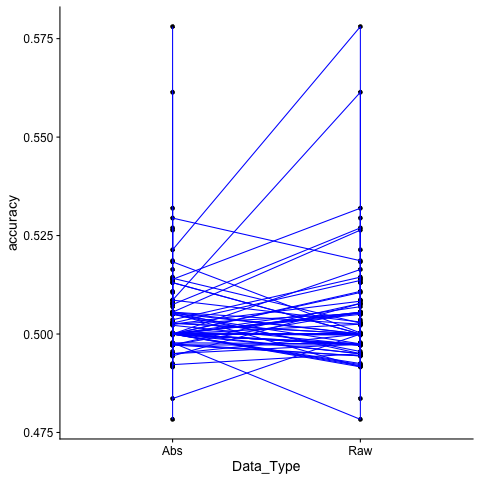

In [51]:
%%R -i comparing_between_stimulus_types_classification_results

comparing_between_stimulus_types_classification_results %>% 
    mutate(stat_identifier = glue("{Statistic}_{Region_Pair}_{relevance_type}_{stimulus_presentation}_{stimulus_combo}")) %>%
    ggplot(data=., mapping=aes(x=Data_Type, y=accuracy)) +
    geom_point() +
    geom_line(aes(group=stat_identifier), color="blue") 